In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import pandas as pd
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold
from scipy import stats
from PIL import Image


/home/grads/a/akshatha.mohan/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/grads/a/akshatha.mohan/anaconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# -----------------------------------------------------------------------------
# From https://en.wikipedia.org/wiki/Minkowski–Bouligand_dimension:
#
# In fractal geometry, the Minkowski–Bouligand dimension, also known as
# Minkowski dimension or box-counting dimension, is a way of determining the
# fractal dimension of a set S in a Euclidean space Rn, or more generally in a
# metric space (X, d).
# -----------------------------------------------------------------------------


# From https://github.com/rougier/numpy-100 (#87)
# From https://gist.github.com/rougier/e5eafc276a4e54f516ed5559df4242c0

import numpy as np


def boxcount(Z, k):
    """
    returns a count of squares of size kxk in which there are both colours (black and white), ie. the sum of numbers
    in those squares is not 0 or k^2
    Z: np.array, matrix to be checked, needs to be 2D
    k: int, size of a square
    """
    S = np.add.reduceat(
        np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
        np.arange(0, Z.shape[1], k), axis=1)  # jumps by powers of 2 squares

    # We count non-empty (0) and non-full boxes (k*k)
    return len(np.where((S > 0) & (S < k * k))[0])


In [3]:


def boxcount_grayscale(Z, k):
    """
    find min and max intensity in the box and return their difference
    Z - np.array, array to find difference in intensities in
    k - int, size of a box
    """
    S_min = np.fmin.reduceat(
        np.fmin.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
        np.arange(0, Z.shape[1], k), axis=1)
    S_max = np.fmax.reduceat(
        np.fmax.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
        np.arange(0, Z.shape[1], k), axis=1)
    return S_max - S_min


In [4]:


def fractal_dimension(Z, threshold=0.9):
    """
    calculate fractal dimension of an object in an array defined to be above certain threshold as a count of squares
    with both black and white pixels for a sequence of square sizes. The dimension is the a coefficient to a poly fit
    to log(count) vs log(size) as defined in the sources.
    :param Z: np.array, must be 2D
    :param threshold: float, a thr to distinguish background from foreground and pick up the shape, originally from
    (0, 1) for a scaled arr but can be any number, generates boolean array
    :return: coefficients to the poly fit, fractal dimension of a shape in the given arr
    """
    # Only for 2d image
    assert (len(Z.shape) == 2)

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2 ** np.floor(np.log(p) / np.log(2))

    # Extract the exponent
    n = int(np.log(n) / np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]



In [5]:

def fractal_dimension_grayscale(Z):
    """
    works the same as fractal_dimension() just does not look at counts and does not require a binary arr rather is looks
    at intensities (hence can be used for a grayscale image) and returns fractal dimensions D_B and D_M (based on sums
    and means), as described in https://imagej.nih.gov/ij/plugins/fraclac/FLHelp/Glossary.htm#grayscale
    :param Z: np. array, must be 2D
    :return: D_B and D_M fractal dimensions based on polyfit to log(sum) or log(mean) resp. vs log(sizes)
    """
    # Only for 2d image
    assert (len(Z.shape) == 2)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2 ** np.floor(np.log(p) / np.log(2))

    # Extract the exponent
    n = int(np.log(n) / np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    i_difference = []
    for size in sizes:
        i_difference.append(boxcount_grayscale(Z, size))

    # D_B
    d_b = [np.sum(x) for x in i_difference]

    # D_M
    d_m = [np.mean(x) for x in i_difference]

    # Fit the successive log(sizes) with log (sum)
    coeffs_db = np.polyfit(np.log(sizes), np.log(d_b), 1)
    # Fit the successive log(sizes) with log (mean)
    coeffs_dm = np.polyfit(np.log(sizes), np.log(d_m), 1)

    return -coeffs_db[0], -coeffs_dm[0]


In [6]:
def fractal_dimension_grayscale_DBC(Z):
    """
    Differential box counting method with implementation of appropriate box height selection.
    :param Z: 2D np.array
    :return: fd for a grayscale image
    """
    # Only for 2d image
    assert (len(Z.shape) == 2)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2 ** np.floor(np.log(p) / np.log(2))

    # Extract the exponent
    n = int(np.log(n) / np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** np.arange(n, 1, -1)

    # get the mean and standard deviation of the image intensity to rescale r
    mu = np.mean(Z)
    sigma = np.std(Z)

    # total number of gray levels, used for computing s'
    G = len(np.unique(Z))

    # scaled scale of each block, r=size(s)
    # TODO -- when to rescale, what should a be
    # when to rescale -- either always or when the pixels in the selected box don't fall in +- 1 std, so far always
    a = 1
    r_prime = sizes / (1 + 2 * a * sigma)

    # Actual box counting with decreasing size
    i_difference = []
    for size in sizes:
        # rescale
        n_r = np.ceil(boxcount_grayscale(Z, size) / r_prime)
        # if max==min per the box, replace the 0 result with 1
        n_r[n_r == 0] = 1
        i_difference.append(n_r)

    # contribution from all boxes
    N_r = [np.sum(x) for x in i_difference]

    # Fit the successive log(sizes) with log (sum)
    coeffs = np.polyfit(np.log(sizes), np.log(N_r), 1)

    return -coeffs[0]


In [7]:
def fractal_dimension_grayscale_DBC(Z):
    """
    Differential box counting method with implementation of appropriate box height selection.
    :param Z: 2D np.array
    :return: fd for a grayscale image
    """
    # Only for 2d image
    assert (len(Z.shape) == 2)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n_exp = 2 ** np.floor(np.log(p) / np.log(2))

    # Extract the exponent
    n_exp = int(np.log(n_exp) / np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2 ** np.arange(n_exp, 1, -1)

    # get the mean and standard deviation of the image intensity to rescale r
    mu = np.mean(Z)
    sigma = np.std(Z)

    # total number of gray levels, used for computing s'
    G = len(np.unique(Z))

    # scaled scale of each block, r=size(s)
    # TODO -- when to rescale, what should a be
    # when to rescale -- either always or when the pixels in the selected box don't fall in +- 1 std, so far always
    a = 1
    r_prime = sizes / (1 + 2 * a * sigma)

    # Actual box counting with decreasing size
    i_difference = []
    
    #Add counter to increment through r_prime
    r_count = 0
    for size in sizes:
        # rescale
        n_r = np.ceil(boxcount_grayscale(Z, size) / r_prime[r_count])
        # if max==min per the box, replace the 0 result with 1
        n_r[n_r == 0] = 1
        i_difference.append(n_r)
        r_count += 1

    # contribution from all boxes
    N_r = [np.sum(x) for x in i_difference]

    # Fit the successive log(sizes) with log (sum)
    coeffs = np.polyfit(np.log(sizes), np.log(N_r), 1)

    return -coeffs[0]


def lacunarity_global(Z, eps = 10e-6):
    '''
    Lacunarity definition from Fast Unsupervised Seafloor Characterization
    in Sonar Imagery Using Lacunarity
    '''
    mean = np.mean(Z)
    std = np.std(Z)
    
    #Lacunarity is the ratio between variance and squared mean
    L = std / ((mean ** 2) + eps)
    
    #Revisist Pytorch implementation
    # #Convert input to tensor
    # Z_tensor = torch.tensor(Z).unsqueeze(0).unsqueeze(0).float()
    
    # #Define sum pooling 
    # sum_pool = nn.AdaptiveAvgPool2d(1)
    
    # #Compute numerator (n * sum of squared pixels) and denominator (squared sum of pixels) 
    # n_pts = np.prod(np.asarray(Z.shape))
    # L_numerator = (n_pts) * sum_pool(n_pts * Z_tensor.square())
    # L_denominator = sum_pool(n_pts * Z_tensor).square()

    # #Lacunarity is L_numerator / L_denominator - 1
    # L_torch = (L_numerator / L_denominator) - 1
    
    # #Convert back to numpy array
    # L_torch = L.squeeze(0).squeeze(0)
    # L_torch = L.detach().cpu().numpy()
    # pdb.set_trace()
    return L
    
def lacunarity_local(Z,kernel_size=[3,3],stride=1,dilation=1):
    '''
    Lacunarity definition from Fast Unsupervised Seafloor Characterization
    in Sonar Imagery Using Lacunarity
    Integral image used
    Leveraging pytorch (may implement as convolution layer later for more flexibility)
    '''
    
    #Convert input to tensor
    Z_tensor = torch.tensor(Z).unsqueeze(0).unsqueeze(0).float()
    
    #Define sum pooling 
    sum_pool = nn.Conv2d(1, 1, kernel_size,stride=stride,dilation=dilation,
                         padding='same',padding_mode='reflect',bias=False)
    
    sum_pool.weight.data = torch.ones(sum_pool.weight.shape) 
    sum_pool.weight.requires_grad = False
    # sum_pool = nn.AvgPool2d(kernel_size,stride=stride,count_include_pad=False,divisor_override=1,
                            # padding=kernel_size[0]//2)
    
    #Compute numerator (n * sum of squared pixels) and denominator (squared sum of pixels) 
    n_pts = np.prod(np.asarray(kernel_size))
    L_numerator = n_pts * sum_pool(Z_tensor.square())
    L_denominator = sum_pool(Z_tensor).square()

    #Lacunarity is L_numerator / L_denominator - 1
    L = (L_numerator / L_denominator) - 1
    
    #Convert back to numpy array
    L = L.squeeze(0).squeeze(0)
    L = L.detach().cpu().numpy()
    
    return L
    
    

In [8]:
data_flag = 'bloodmnist'
download = True

BATCH_SIZE = 128


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [9]:
# preprocessing
data_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224,scale=(.8,1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5]),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/grads/a/akshatha.mohan/.medmnist/bloodmnist.npz


Using downloaded and verified file: /home/grads/a/akshatha.mohan/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/grads/a/akshatha.mohan/.medmnist/bloodmnist.npz


In [10]:
images, labels = next(iter(train_loader))

In [11]:
images[0]
image_array = images[120].numpy()
image_array.shape


(3, 224, 224)

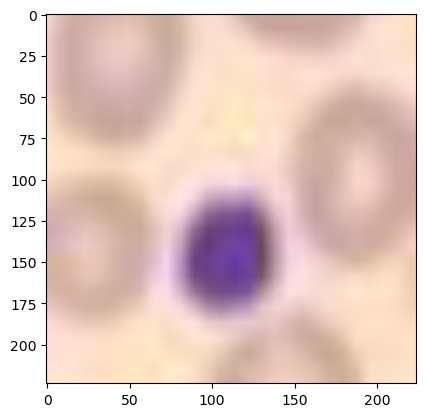

In [12]:
plt.imshow(np.transpose((images[120]*0.5+0.5).to('cpu').numpy(), (1, 2, 0)))
plt.show()

In [13]:
class Global_Lacunarity(nn.Module):
    def __init__(self, dim=2, eps = 10E-6, kernel = None, stride = None, padding = None):


        # inherit nn.module
        super(Global_Lacunarity, self).__init__()

        # define layer properties
        self.dim = dim
        self.eps = eps
        self.kernel = kernel
        self.stride = stride
        self.padding = padding

        #For each data type, apply two 1x1 convolutions, 1) to learn bin center (bias)
        # and 2) to learn bin width
        # Time series/ signal Data
        if self.kernel is None:
            if self.dim == 1:
                self.gap_layer = nn.AdaptiveAvgPool1d(1)
            
            # Image Data
            elif self.dim == 2:
                self.gap_layer = nn.AdaptiveAvgPool2d(1)
            
            # Spatial/Temporal or Volumetric Data
            elif self.dim == 3:
                self.gap_layer = nn.AdaptiveAvgPool3d(1)
             
            else:
                raise RuntimeError('Invalid dimension for global lacunarity layer')
        else:
            if self.dim == 1:
                self.gap_layer = nn.AvgPool1d((kernel[0]), stride=stride[0], padding=(0))
            
            # Image Data
            elif self.dim == 2:
                self.gap_layer = nn.AvgPool2d((kernel[0], kernel[1]), stride=(stride[0], stride[1]), padding=(0, 0))
            
            # Spatial/Temporal or Volumetric Data
            elif self.dim == 3:
                self.gap_layer = nn.AvgPool3d((kernel[0], kernel[1], kernel[2]), stride=(stride[0], stride[1], stride[2]), padding=(0, 0, 0))
             
            else:
                raise RuntimeError('Invalid dimension for global lacunarity layer')

        
    def forward(self,x):
        #Compute squared tensor
        #pdb.set_trace()
        squared_x_tensor = x ** 2

        #Get number of samples 
        n_pts = np.prod(np.asarray(self.kernel))

        #Compute numerator (n * sum of squared pixels) and denominator (squared sum of pixels)
        L_numerator = ((n_pts)**2) * (self.gap_layer(squared_x_tensor))
        L_denominator = (n_pts * self.gap_layer(x))**2

        #Lacunarity is L_numerator / L_denominator - 1
        x = (L_numerator / (L_denominator + self.eps)) - 1
        y = lambda_param = 0.5  # Change the lambda parameter as needed
        y = (torch.pow(x.abs() + 1, lambda_param) - 1) / lambda_param

        #pdb.set_trace()
        return y
  


In [14]:
images[120].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


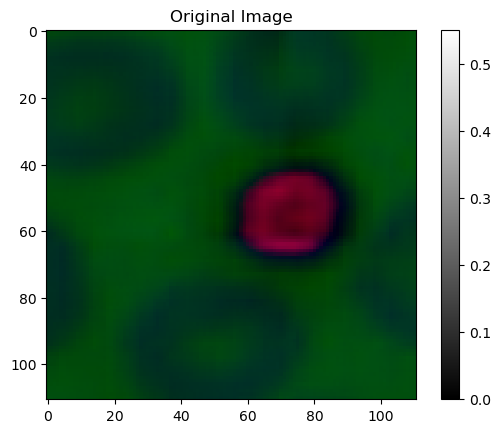

In [45]:
X = images[120]
conv = nn.Conv2d(3, out_channels=3, kernel_size=3, stride=2)
conv_output = conv(X)
# Plot the image
plt.imshow(conv_output.permute(2,1,0).detach().numpy(), cmap = 'gray')
plt.colorbar()
plt.title('Original Image')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


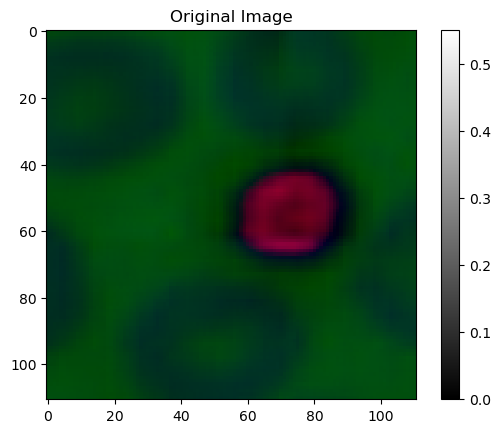

In [46]:
relu = nn.ReLU()
relu_output = relu(conv_output)
# Plot the image
plt.imshow(conv_output.permute(2,1,0).detach().numpy(), cmap='gray')
plt.colorbar()
plt.title('Original Image')
plt.show()

/tmp/ipykernel_758704/2854718614.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(lac_pooling_output).permute(2,1,0).detach().numpy(), cmap='gray')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


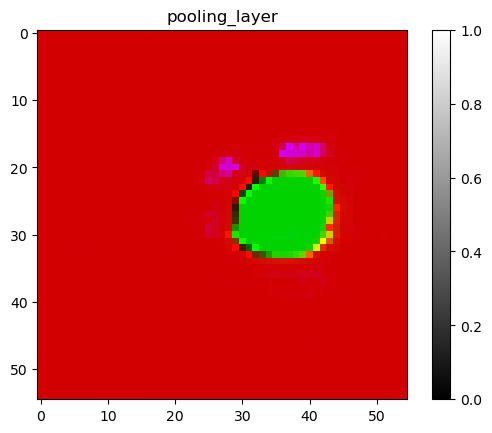

In [47]:
lac_pooling_layer = Global_Lacunarity(kernel=(2,2), stride=(2,2), padding=(0,0))
lac_pooling_output = lac_pooling_layer(relu_output)
# Plot the image
plt.imshow(torch.tensor(lac_pooling_output).permute(2,1,0).detach().numpy(), cmap='gray')
plt.colorbar()
plt.title('pooling_layer')
plt.show()

In [48]:
lac_pooling_output

tensor([[[8.2843e-01, 8.2843e-01, 8.2843e-01,  ..., 8.2843e-01,
          8.2843e-01, 8.2843e-01],
         [8.2843e-01, 8.2843e-01, 8.2843e-01,  ..., 8.2843e-01,
          8.2843e-01, 8.2843e-01],
         [8.2843e-01, 8.2843e-01, 8.2843e-01,  ..., 8.2843e-01,
          8.2843e-01, 8.2843e-01],
         ...,
         [8.2843e-01, 8.2843e-01, 8.2843e-01,  ..., 8.2843e-01,
          8.2843e-01, 8.2843e-01],
         [8.2843e-01, 8.2843e-01, 8.2843e-01,  ..., 8.2843e-01,
          8.2843e-01, 8.2843e-01],
         [8.2843e-01, 8.2843e-01, 8.2843e-01,  ..., 8.2843e-01,
          8.2843e-01, 8.2843e-01]],

        [[4.4727e-04, 6.4135e-04, 3.7742e-04,  ..., 4.7922e-05,
          7.2002e-05, 2.6226e-06],
         [5.4741e-04, 9.7299e-04, 5.3644e-04,  ..., 6.2466e-05,
          5.2214e-05, 5.0068e-06],
         [4.0603e-04, 9.0981e-04, 5.5313e-04,  ..., 9.5367e-07,
          5.7220e-06, 2.5511e-05],
         ...,
         [1.4853e-04, 1.2159e-05, 1.3351e-05,  ..., 1.6212e-05,
          4.530

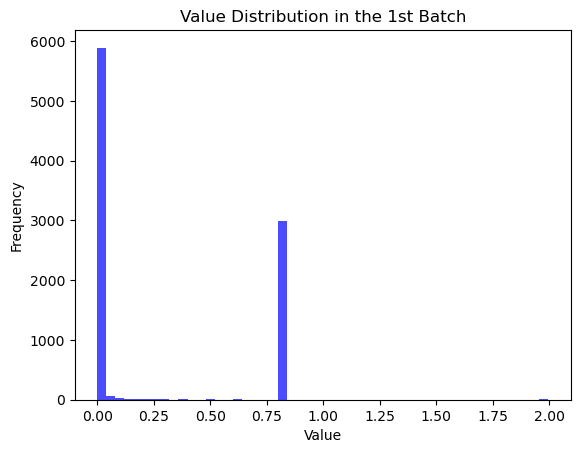

In [49]:
lac_flat_data = lac_pooling_output.view(-1).detach().numpy()

# Plot the histogram
plt.hist(lac_flat_data, bins=50, alpha=0.7, color='b')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Value Distribution in the 1st Batch')
plt.show()

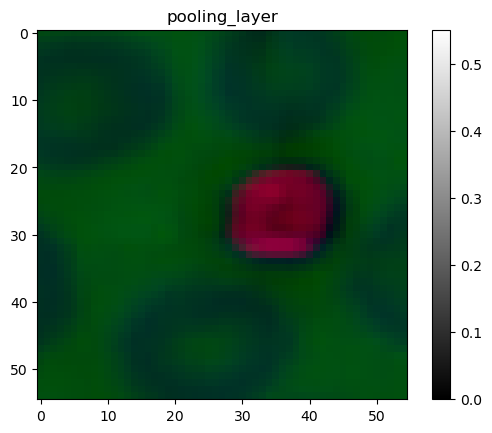

In [50]:
max_pooling_layer = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
max_pooling_output = max_pooling_layer(relu_output)
# Plot the image
plt.imshow(max_pooling_output.permute(2,1,0).detach().numpy(), cmap='gray')
plt.colorbar()
plt.title('pooling_layer')
plt.show()

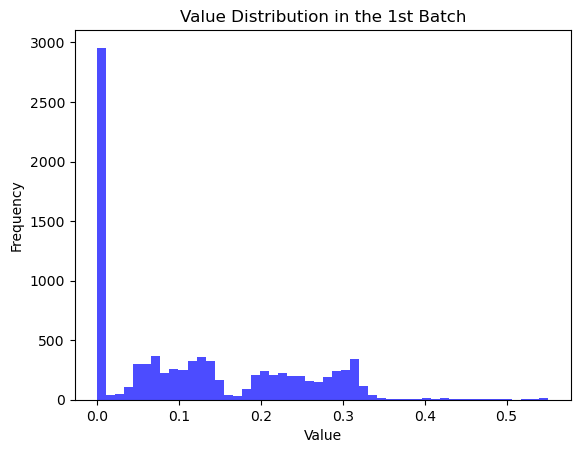

In [51]:
max_flat_data = max_pooling_output.view(-1).detach().numpy()

# Plot the histogram
plt.hist(max_flat_data, bins=50, alpha=0.7, color='b')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Value Distribution in the 1st Batch')
plt.show()

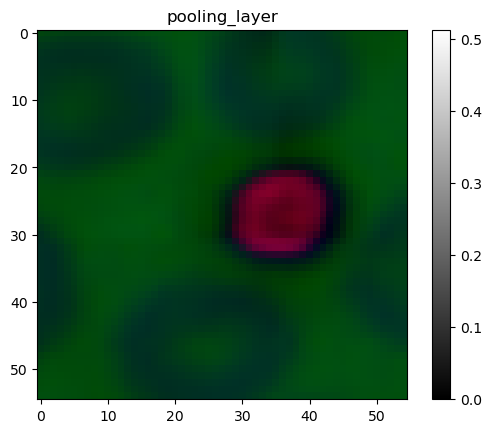

In [52]:
avg_pooling_layer = nn.AvgPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
avg_pooling_output = avg_pooling_layer(relu_output)
# Plot the image
plt.imshow(avg_pooling_output.permute(2,1,0).detach().numpy(), cmap='gray')
plt.colorbar()
plt.title('pooling_layer')
plt.show()

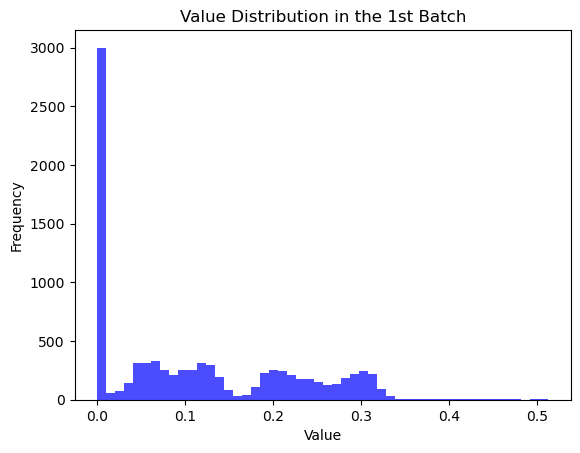

In [53]:
avg_flat_data = avg_pooling_output.view(-1).detach().numpy()

# Plot the histogram
plt.hist(avg_flat_data, bins=50, alpha=0.7, color='b')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Value Distribution in the 1st Batch')
plt.show()

In [41]:
#load image, if you use grayscale iamge, cosine similarity will be 1 (input dim = 1)
X = images[120]


#Compute similarity feature (currenlty have 'norm' or 'cosine')
channels = X.shape[1]
Lancunarity_Layer = Global_Lacunarity(kernel=(3,3), stride=(2,2), padding=(0,0))
similarity_features = Lancunarity_Layer(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


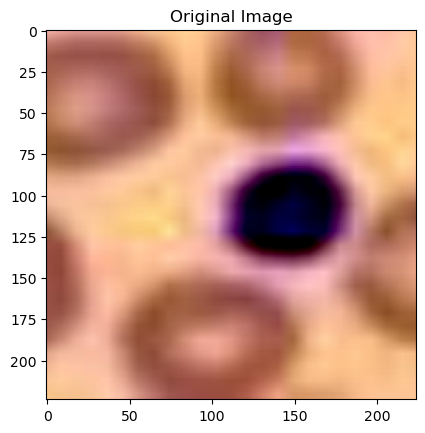

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


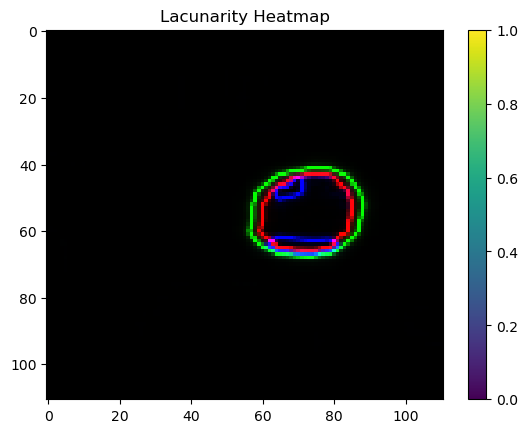

In [42]:
import matplotlib.pyplot as plt
import torch

# Assuming similarity_features has shape [1, 28, 1, 13]
similarity_features_reshaped = similarity_features.squeeze().detach().numpy()

# Plot the image
plt.imshow(X.squeeze().permute(2,1,0).numpy(), cmap='gray')
plt.title('Original Image')
plt.show()

# Plot the lacunarity values as a heatmap
plt.imshow(similarity_features.squeeze().permute(2,1,0).numpy(), cmap='viridis', aspect='auto')
plt.title('Lacunarity Heatmap')
plt.colorbar()
plt.show()


In [43]:
gray_image = Image.fromarray((image_array.mean(axis=0) * 255).astype('uint8'), 'L')
gray_image = np.array(gray_image)

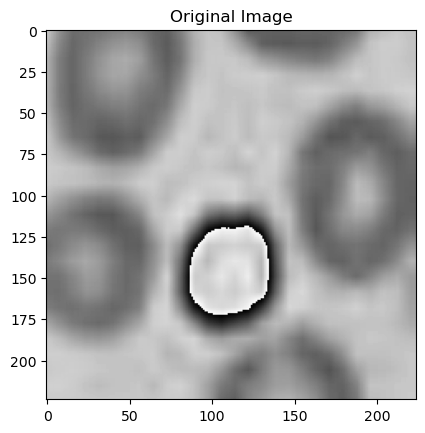

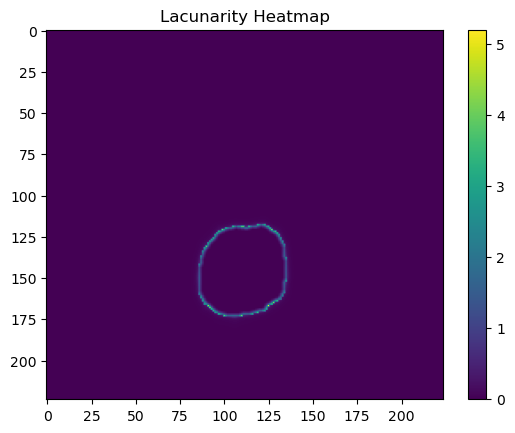

In [44]:
temp = lacunarity_local(gray_image)
temp.shape

# Plot the image
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.show()

# Plot the lacunarity values as a heatmap
plt.imshow(temp, cmap='viridis', aspect='auto')
plt.title('Lacunarity Heatmap')
plt.colorbar()
plt.show()

In [28]:
class Net(nn.Module):
    def __init__(self, num_ftrs, num_classes, pooling_layer="lacunarity", agg_func="global"):
        super(Net, self).__init__()

        self.agg_func = agg_func
        if agg_func == "global":
            if pooling_layer == "max":
                self.pooling_layer = nn.AdaptiveMaxPool2d(1)
            elif pooling_layer == "avg":
                self.pooling_layer = nn.AdaptiveAvgPool2d(1)
            elif pooling_layer == "lacunarity":
                self.pooling_layer = Global_Lacunarity()
        elif agg_func == "local":
            if pooling_layer == "max":
                self.pooling_layer = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
            elif pooling_layer == "avg":                                                                                                                                                                                                                            
                self.pooling_layer = nn.AvgPool2d((3, 3), stride=(2, 2), padding=(0, 0))
            elif pooling_layer == "lacunarity":
                self.pooling_layer = Global_Lacunarity(kernel=(11,11), stride=(2,2), padding=(0,0))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, out_channels=3, kernel_size=3, stride=2),
            nn.ReLU(),
            self.pooling_layer,
        )
        self.fc = nn.Linear(num_ftrs, num_classes)



    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x    
    